In [ ]:
import tqdm  # TODO: Agregar un poetry o requirements...
import json
import pandas as pd
import requests

SHEET_ID = '1b6h2RApBs2xbN6-eGVvxH68EALKDklvS91fb7d_IVz4'
SHEET_TABS = {
    'REGISTROS': 2103959160,
    'REGISTROS-ALL': 1249987488,
    'USUARIOS': 102021014,
    'USUARIOS-ALL': 1608673456,
}
SHEET_URL = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/export?format=csv&gid={SHEET_TABS["REGISTROS"]}'
SHEET_URL

'https://docs.google.com/spreadsheets/d/1b6h2RApBs2xbN6-eGVvxH68EALKDklvS91fb7d_IVz4/export?format=csv&gid=2103959160'

In [ ]:
df_registros = pd.read_csv(SHEET_URL)
df_registros.head()

,Timestamp,Padron,Carrera,Mapa
0,9/28/2022 19:41:35,103942,electronica,"{""materias"":[{""id"":""CBC66"",""nota"":5},{""id"":""CB..."
1,9/28/2022 19:35:26,103942,informatica,"{""materias"":[{""id"":""CBC"",""nota"":0},{""id"":""62.0..."
2,9/28/2022 19:35:01,108026,informatica,"{""materias"":[{""id"":""CBC28"",""nota"":9},{""id"":""CB..."
3,9/28/2022 19:23:11,101621,civil,"{""materias"":[{""id"":""CBC28"",""nota"":9},{""id"":""CB..."
4,9/28/2022 18:12:04,104177,agrimensura,"{""materias"":[{""id"":""CBC"",""nota"":0}],""checkboxe..."


In [ ]:
print(f"Remuevo los {df_registros[df_registros['Padron'].isnull()]['Timestamp'].count()} registros invalidos")
df_registros = df_registros[df_registros['Padron'].notnull()]
df_registros.head()

Remuevo los 11 registros invalidos


,Timestamp,Padron,Carrera,Mapa
0,9/28/2022 19:41:35,103942,electronica,"{""materias"":[{""id"":""CBC66"",""nota"":5},{""id"":""CB..."
1,9/28/2022 19:35:26,103942,informatica,"{""materias"":[{""id"":""CBC"",""nota"":0},{""id"":""62.0..."
2,9/28/2022 19:35:01,108026,informatica,"{""materias"":[{""id"":""CBC28"",""nota"":9},{""id"":""CB..."
3,9/28/2022 19:23:11,101621,civil,"{""materias"":[{""id"":""CBC28"",""nota"":9},{""id"":""CB..."
4,9/28/2022 18:12:04,104177,agrimensura,"{""materias"":[{""id"":""CBC"",""nota"":0}],""checkboxe..."


In [ ]:
# TODOs:
# - joinear con "usuarios" para obtener orientacion y tpp/tesis
# - ver si podemos rescatar "checkboxes" del json_mapa
# - ver si podemos migrar el legacy "materia_cuatri" con el nuevo "materia_cuatrimestre"
dfr = df_registros
df_mapas = None
for idx in tqdm.tqdm(dfr.index):
    json_mapa = json.loads(dfr.loc[idx]['Mapa'])
    df_materias = pd.json_normalize(json_mapa['materias'])
    
    if 'optativas' not in json_mapa:
        df_optativas = pd.DataFrame()
    else:
        df_optativas = pd.json_normalize(json_mapa['optativas'])

    df_materias = df_materias.add_prefix('materia_')
    df_optativas = df_optativas.add_prefix('optativa_')

    df_map = pd.concat([df_materias, df_optativas]).reset_index(drop=True)
    df_map['Padron'] = dfr.loc[idx]['Padron']
    df_map['Carrera'] = dfr.loc[idx]['Carrera']
    df_map['Timestamp'] = dfr.loc[idx]['Timestamp']
    
    if df_mapas is None:
        df_mapas = df_map
    else:
        df_mapas = pd.concat([df_mapas, df_map])

100%|███████████████████████████████████████████████████████████████████████████████████| 4322/4322 [00:40<00:00, 106.93it/s]


In [ ]:
df_mapas.sample(5)

,materia_id,materia_nota,Padron,Carrera,Timestamp,materia_cuatrimestre,optativa_id,optativa_nombre,optativa_creditos,materia_cuatri
3,91.19,0.0,1123213,electronica,2/8/2021 12:57:12,NaN,NaN,NaN,NaN,NaN
33,91.07,6.0,100096,industrial,7/26/2022 13:45:39,NaN,NaN,NaN,NaN,NaN
17,71.40,-2.0,105634,informatica,8/24/2022 11:23:23,2023.5,NaN,NaN,NaN,NaN
18,66.20,4.0,102223,informatica,8/18/2022 0:50:03,NaN,NaN,NaN,NaN,NaN
39,91.22,-2.0,104458,industrial,8/12/2022 10:29:57,2022.5,NaN,NaN,NaN,NaN


In [ ]:
df_mapas.shape

(95928, 10)

In [ ]:
# Vamos a armar un grafazo: 
# nodos -> usuarios. 
# flechas -> cursar misma materia mismo cuatri. 
# TODO: peso de flechas -> correlacion entre notas
from itertools import combinations

df_informatica = df_mapas[df_mapas['Carrera'] == 'informatica']
df_informatica = df_informatica[df_informatica['materia_cuatrimestre'].notnull()]
df_informatica = df_informatica[['materia_id', 'materia_nota', 'materia_cuatrimestre', 'Padron']]

d = (df_informatica
     .groupby(['materia_id', 'materia_cuatrimestre'])[['Padron', 'materia_nota']]
     .apply(lambda x : list(combinations(x.values,2)))
     .apply(pd.Series)
     .stack()
     .reset_index(level=0, name='Usuarios')
)

d = d.reset_index()
d[['src', 'dst']] = d['Usuarios'].tolist()
d[['src_padron', 'src_nota']] = d['src'].tolist()
d[['dst_padron', 'dst_nota']] = d['dst'].tolist()
d = d[['src_padron', 'dst_padron', 'materia_cuatrimestre', 'materia_id', 'src_nota', 'dst_nota']]

# Testing
# d = d[((d['src_padron'] == '100029') & (d['dst_padron'] == '101696')) | ((d['src_padron'] == '101696') & (d['dst_padron'] == '100029'))]


/tmp/ipykernel_186481/3141892815.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  .apply(pd.Series)


In [ ]:
import networkx as nx
G = nx.from_pandas_edgelist(d, 
                            source='src_padron', 
                            target='dst_padron', 
                            edge_attr=['materia_id','materia_cuatrimestre', 'src_nota', 'dst_nota'], 
                            create_using=nx.MultiGraph())

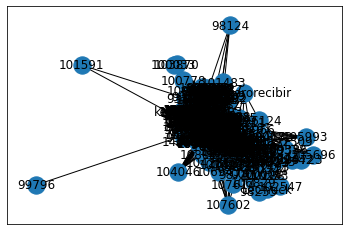

In [ ]:
nx.draw_networkx(G)

In [ ]:
print(G)
print(f"""
  El diámetro de la red: {nx.diameter(G)}
  El grado promedio de la red: {sum([n[1] for n in G.degree()]) / len(G):.2f}
  TODO: Los allegados promedio de la red: 
  Puentes globales: {list(nx.bridges(G))}
""")


MultiGraph with 381 nodes and 129692 edges

  El diámetro de la red: 4
  El grado promedio de la red: 680.80
  TODO: Los allegados promedio de la red: 


  Puentes globales: [('98439', '99796')]



In [ ]:
from networkx.algorithms import community
louvain = community.louvain_communities(G)

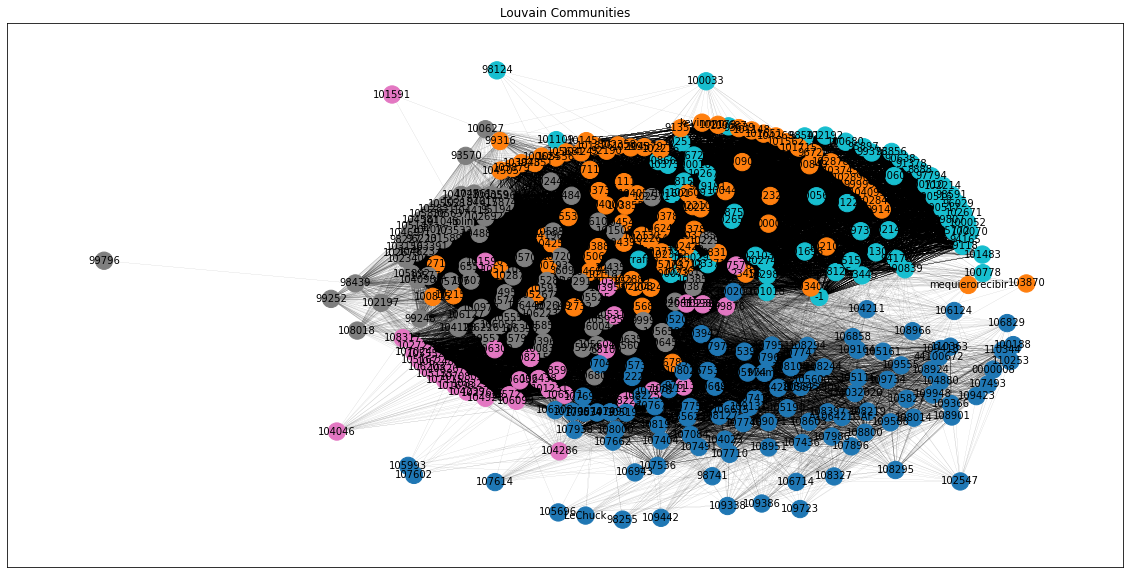

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

plt.figure(figsize=(20,10))

draw_nodes = {}
colors = random.sample(list(mcolors.TABLEAU_COLORS), len(louvain))
for louvaincommunity, color in zip(louvain, colors):
    draw_nodes.update({n: color for n in louvaincommunity})
    
plt.title("Louvain Communities")
nx.draw_networkx(G, 
                 nodelist=draw_nodes.keys(), 
                 node_color=list(draw_nodes.values()), 
                 width=0.05, 
                 pos=nx.kamada_kawai_layout(G),
                 font_size=10)

In [ ]:
# Todo: sacar distribucion de padrones de cada comunidad, para poder clasificar
# as in "esta es la comunidad de los jovenes, esta es la de los viejos, esta no tiene patron, etc"
louvain

[{'-1',
  '100016',
  '100029',
  '100033',
  '100052',
  '100070',
  '100073',
  '100516',
  '100517',
  '100560',
  '100608',
  '100680',
  '100687',
  '100710',
  '100778',
  '100839',
  '100866',
  '101018',
  '101109',
  '101228',
  '101302',
  '101483',
  '101601',
  '101696',
  '102103',
  '102140',
  '102192',
  '102214',
  '102342',
  '102361',
  '102510',
  '102654',
  '102671',
  '102674',
  '102740',
  '102981',
  '103371',
  '103732',
  '8888',
  '90638',
  '91378',
  '919191',
  '93445',
  '94165',
  '94178',
  '95159',
  '95772',
  '95897',
  '96029',
  '96728',
  '96856',
  '97794',
  '98124',
  '98125',
  '98153',
  '98541',
  '98591',
  '98752',
  '99118',
  '99373',
  '99732',
  '99807',
  'fsrrafpp'},
 {'0000',
  '100445',
  '100624',
  '100815',
  '100849',
  '100901',
  '101148',
  '101187',
  '101456',
  '101562',
  '101651',
  '101715',
  '101826',
  '102102',
  '102130',
  '102150',
  '102179',
  '102208',
  '102210',
  '102216',
  '102219',
  '102264',
  '1023

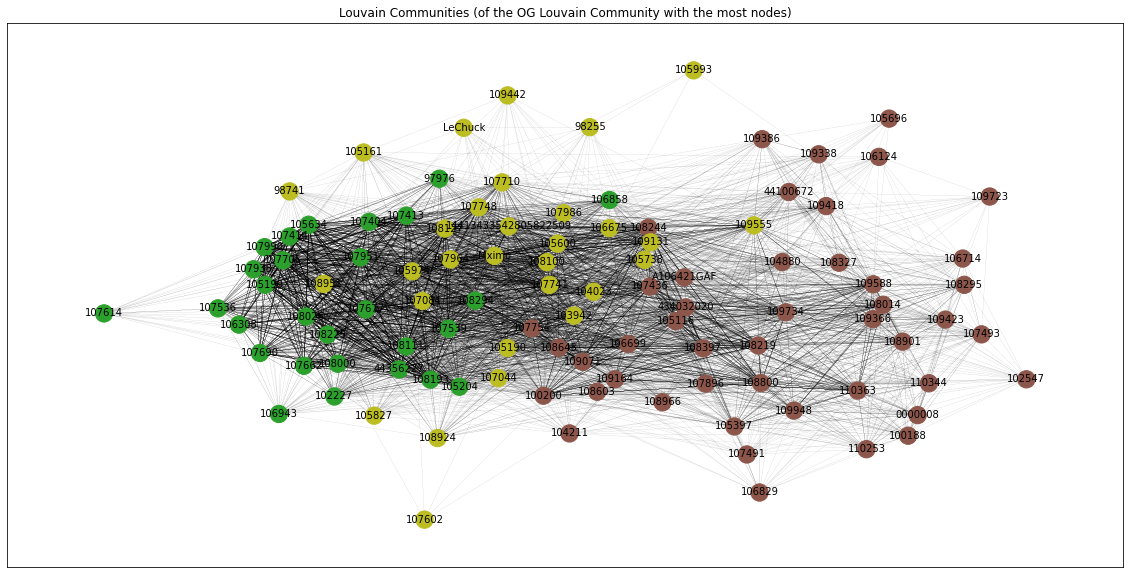

In [ ]:
subnetwork = nx.subgraph(G, max(louvain, key=len))
subnetwork_louvain = community.louvain_communities(subnetwork)
plt.figure(figsize=(20,10))

draw_nodes = {}
colors = random.sample(list(mcolors.TABLEAU_COLORS), len(subnetwork_louvain))
for louvain, color in zip(subnetwork_louvain, colors):
    draw_nodes.update({n: color for n in louvain})
    
plt.title("Louvain Communities (of the OG Louvain Community with the most nodes)")
nx.draw_networkx(subnetwork, 
                 nodelist=draw_nodes.keys(), 
                 node_color=list(draw_nodes.values()), 
                 width=0.05, 
                 pos=nx.kamada_kawai_layout(subnetwork),
                 font_size=10)

In [ ]:
subnetwork_louvain

[{'104023',
  '104211',
  '105190',
  '105600',
  '105827',
  '106675',
  '106943',
  '107044',
  '107084',
  '107986',
  '108924',
  '108951',
  '108966',
  '109131',
  '109442',
  '109555',
  '14413433542805822509',
  '98255',
  '98741',
  'LeChuck',
  'Mximo'},
 {'102227',
  '103942',
  '105161',
  '105199',
  '105204',
  '105634',
  '105974',
  '106308',
  '106858',
  '107404',
  '107413',
  '107414',
  '107536',
  '107539',
  '107614',
  '107662',
  '107677',
  '107690',
  '107705',
  '107710',
  '107741',
  '107748',
  '107938',
  '107951',
  '107964',
  '107990',
  '108000',
  '108026',
  '108100',
  '108111',
  '108127',
  '108193',
  '108225',
  '108294',
  '44356227',
  '97976'},
 {'0000008',
  '100188',
  '100200',
  '102547',
  '104880',
  '105116',
  '105397',
  '105696',
  '105738',
  '105993',
  '106124',
  '106699',
  '106714',
  '106829',
  '107436',
  '107491',
  '107493',
  '107602',
  '107754',
  '107896',
  '108014',
  '108219',
  '108244',
  '108295',
  '108327',


In [ ]:
# todo: usar graphrole y rolx

In [ ]:
# todo: ejercicio 5 de parcialito 3

In [ ]:
# todo: leer TODA la documentacion de "algorithms" de nx y ver que aplica aca
# https://networkx.org/documentation/stable/reference/algorithms/index.html

In [ ]:
# todo: plantear preguntas y resolverlas con comunidades:
# "que electivas curso?"
# "que cuatrimestre armo?"